In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\Work\AppData\Local\Temp\ipykernel_9456\930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [9]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print("Most recent date in the data set:", most_recent_date)

Most recent date in the data set: 2017-08-23


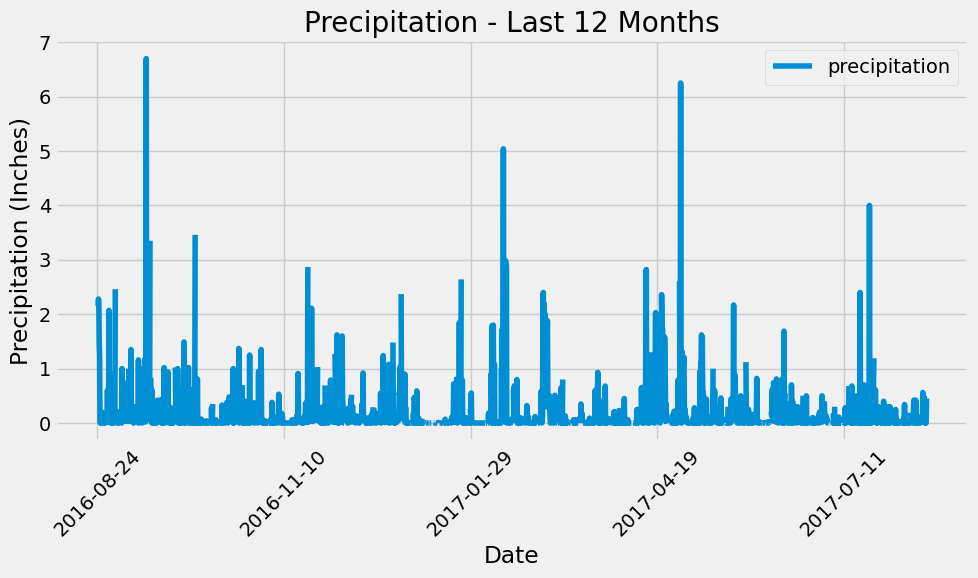

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)

# Sort the dataframe by date
df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(10, 6))
plt.title("Precipitation - Last 12 Months")
plt.ylabel("Precipitation (Inches)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df.describe()

print(summary_statistics)

       precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print("Total number of stations in the dataset:", total_stations)

Total number of stations in the dataset: 9


In [26]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
most_active_station_results = session.query(
    Measurement.station, 
    func.count(Measurement.station)
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# List the stations and their counts in descending order.
for station, count in most_active_station_results:
    print(f"Station {station} has {count} measurements.")

Station USC00519281 has 2772 measurements.
Station USC00519397 has 2724 measurements.
Station USC00513117 has 2709 measurements.
Station USC00519523 has 2669 measurements.
Station USC00516128 has 2612 measurements.
Station USC00514830 has 2202 measurements.
Station USC00511918 has 1979 measurements.
Station USC00517948 has 1372 measurements.
Station USC00518838 has 511 measurements.


In [27]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_station_results[0][0]

# Design a query to find the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station_id).one()

lowest_temp, highest_temp, avg_temp = temperature_stats

print(f"Most Active Station: {most_active_station_id}")
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp:.2f}")

Most Active Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


<Figure size 1000x600 with 0 Axes>

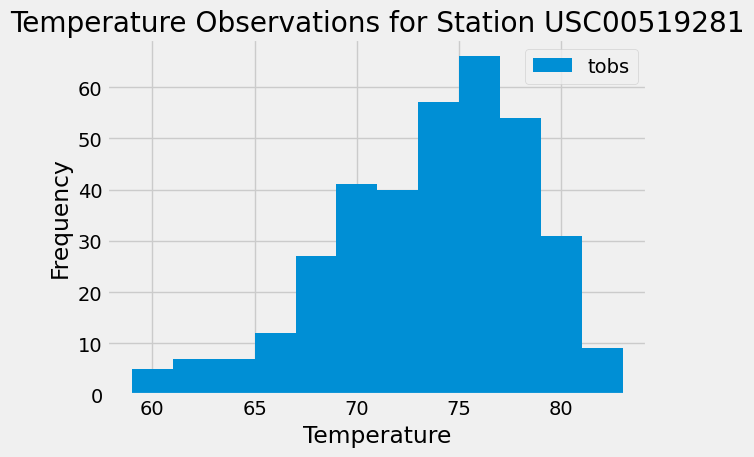

In [29]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Find the most recent date for the most active station
most_recent_date = session.query(func.max(Measurement.date)).filter(Measurement.station == most_active_station_id).scalar()
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for this station
temperature_results = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).all()

# Convert query results to Pandas DataFrame
temperature_df = pd.DataFrame(temperature_results, columns=['tobs'])

# Close the session
session.close()

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
temperature_df.plot.hist(bins=12)
plt.title(f"Temperature Observations for Station {most_active_station_id}")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Close Session

In [30]:
# Close Session
session.close()